In [130]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

# Global Figures
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"

# Step 1: Data Understanding and Preprocessing 
- Inspect the data
- Check for missing values
- Check outliers 
- Create new variables for potential further insights

In [113]:
# Load the dataset and check it
df = pd.read_csv(r"C:\Users\sebas\OneDrive - BI Norwegian Business School (BIEDU)\GitHub\Portfolio\Predicting Customer Churn\Data\synthetic_churn_data.csv")
print("Data Shape:", df.shape)   # (Rows, columns)
print(df.head())
print(df.info())

Data Shape: (10000, 10)
   customer_id  age  gender subscription_tier  usage_count  last_login_days_ago  late_payments_6m  monthly_spend         region  churn
0            1   56  Female          Standard           24                    0                 0          44.85  North America      1
1            2   69    Male          Standard           10                    0                 0          47.12         Europe      0
2            3   46  Female          Standard           16                   57                 0          48.12           Asia      1
3            4   32    Male           Premium           14                   23                 0         106.11           Asia      0
4            5   60    Male           Premium           12                    0                 0          97.36           Asia      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ---

In [115]:
# Step 1.1 Data Overview

## Some descriptive statistics 
print(df.describe())

## Summaries of churn distribution
print("Churn Value Counts:")
print(df["churn"].value_counts())    # 8748 no churn, 1252 churns

## Checking for missing values
print(df.isnull().sum()) 

       customer_id           age   usage_count  last_login_days_ago  late_payments_6m  monthly_spend         churn
count  10000.00000  10000.000000  10000.000000         10000.000000      10000.000000   10000.000000  10000.000000
mean    5000.50000     44.021700     15.015700            21.674900          0.209800      47.792584      0.287500
std     2886.89568     15.203998      3.883293            18.572186          0.464549      29.892358      0.452619
min        1.00000     18.000000      3.000000             0.000000          0.000000       4.710000      0.000000
25%     2500.75000     31.000000     12.000000             4.000000          0.000000      21.267500      0.000000
50%     5000.50000     44.000000     15.000000            19.000000          0.000000      46.460000      0.000000
75%     7500.25000     57.000000     18.000000            36.000000          0.000000      55.822500      1.000000
max    10000.00000     70.000000     31.000000            60.000000          4.0

### Step 1.1: Data overview summary
- No missing values in dataset
- Key statistics:
    - Age: Ranges from 18 to 70 years, with a mean of 44.
    - Usage Count: Varies between 3 and 31, with an average of 15.
    - Last Login (Days Ago): 0 to 60 days, mean of ~22 days.
    - Late Payments (Last 6 Months): 0 to 4, with most users having 0.
    - Monthly Spend: Ranges from ~4.71 to ~116.90, with an average of ~47.79.
    - Churn Rate: 12.52% (mean = 0.1252), indicating a moderately low churn rate.


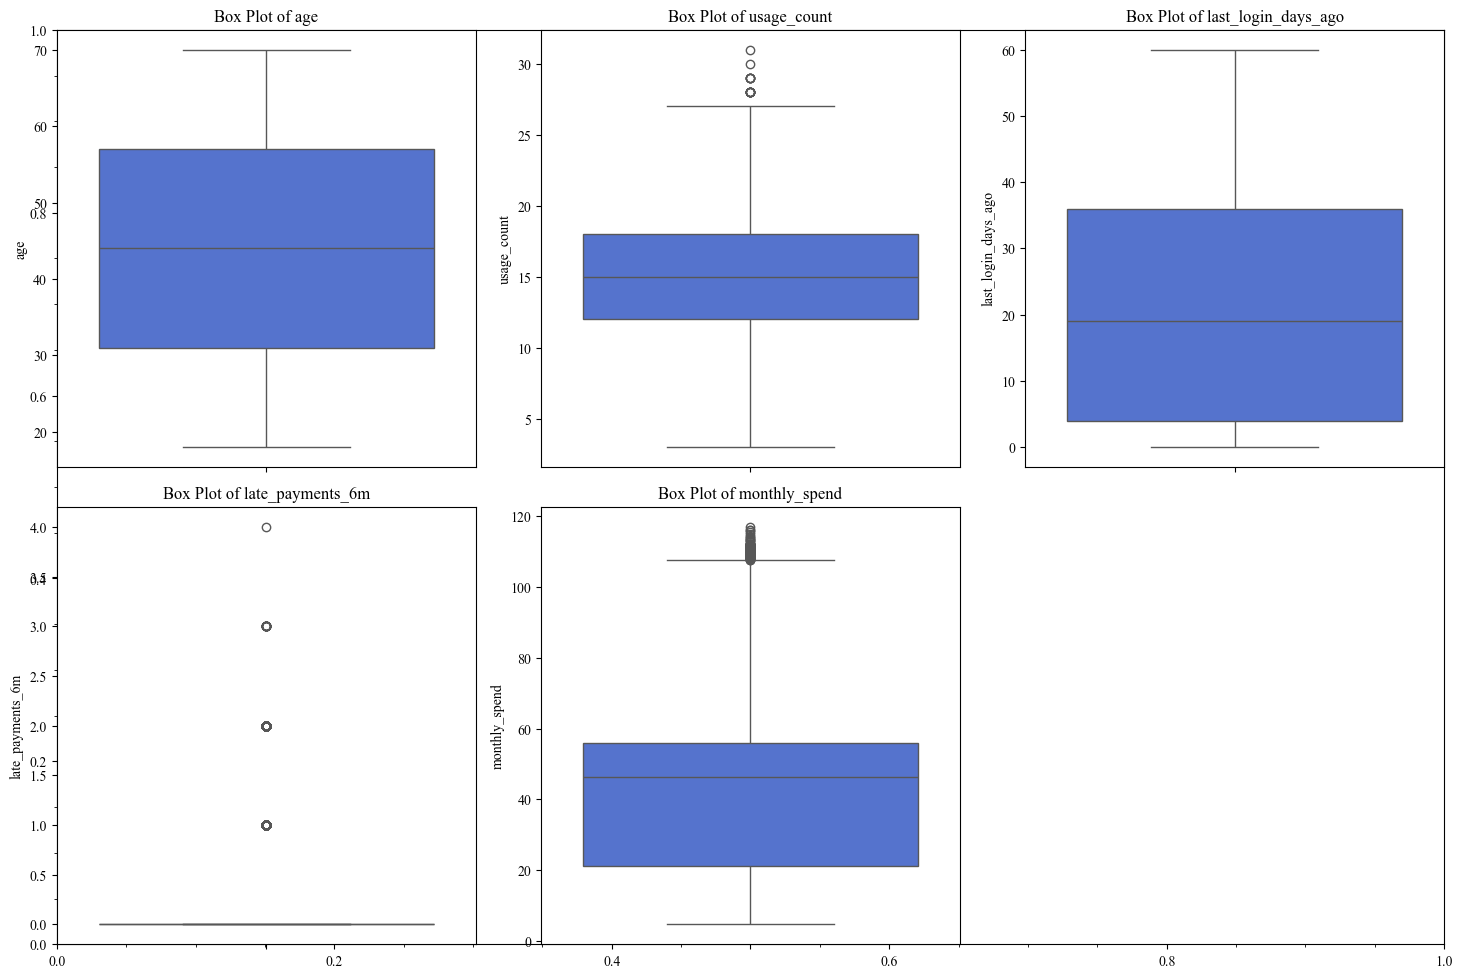

In [116]:
# Step 1.2: Outlier detection 

# Plot box plots for numerical features to detect potential outliers 
numerical_columns = ["age", "usage_count", "last_login_days_ago", "late_payments_6m", "monthly_spend"]
plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color = "royalblue")
    plt.title(f"Box Plot of {col}")
plt.tight_layout()
plt.show()

**From the box plots:**
- Age: No significant outliers.
- Usage Count: A few high outliers beyond 25+.
- Last Login Days Ago: Potential outliers near the maximum (60 days).
- Late Payments (6 Months): A few outliers at 3 and 4 payments.
- Monthly Spend: Some high spend outliers beyond 100.

In [117]:
## Step 1.2: Further investiagtion of outliers 

# Define a function to get outlier based on IQR 
def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1 
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Check for outliers in each numerical column 
outliers_summary = {}
for col in numerical_columns:
    outliers = get_outliers(df, col)
    outliers_summary[col] = {
        "outlier_count": len(outliers),
        "percentage": round((len(outliers) / len(df))*100, 2)
    }
outliers_summary

{'age': {'outlier_count': 0, 'percentage': 0.0},
 'usage_count': {'outlier_count': 16, 'percentage': 0.16},
 'last_login_days_ago': {'outlier_count': 0, 'percentage': 0.0},
 'late_payments_6m': {'outlier_count': 1874, 'percentage': 18.74},
 'monthly_spend': {'outlier_count': 139, 'percentage': 1.39}}

- Age: No outliers detected.
- Usage Count: 16 outliers (0.16%). Minimal impact, likely valid users.
- Last Login Days Ago: No outliers detected.
- Late Payments (6 Months): 1,874 outliers (18.74%). Significant proportion, suggesting a need for deeper investigation.
- Monthly Spend: 139 outliers (1.39%). Worth checking if they are legitimate high spenders.

In [118]:
# Step 1.2: Detailed analysis of outliers in late payments and monthly spend 

# Extract outliers for late payments and monthly spend 
late_payments_outliers = get_outliers(df, "late_payments_6m")
monthly_spend_outliers = get_outliers(df, "monthly_spend")

# Summary stats. for outliers 
late_payments_summary = late_payments_outliers["late_payments_6m"].describe()
monthly_spend_summary = monthly_spend_outliers["monthly_spend"].describe()

(late_payments_summary, monthly_spend_summary)

(count    1874.000000
 mean        1.119530
 std         0.364777
 min         1.000000
 25%         1.000000
 50%         1.000000
 75%         1.000000
 max         4.000000
 Name: late_payments_6m, dtype: float64,
 count    139.000000
 mean     109.914317
 std        1.988441
 min      107.660000
 25%      108.375000
 50%      109.370000
 75%      111.110000
 max      116.900000
 Name: monthly_spend, dtype: float64)

1. Late Payments (6 Months) Outliers
    - Count: 1,874 outliers.
    - Mean: 1.12 (mostly 1 late payment).
    - Range: 1 to 4 late payments.
    - **Insight:** Most outliers have only 1 late payment, suggesting the threshold for outliers is low. The maximum of 4 might be legitimate.
2. Monthly Spend Outliers
    - Count: 139 outliers.
    - Mean: ~109.91.
    - Range: 107.66 to 116.90.
    - **Insight:** High spenders with a tight range, likely valid. Potentially premium users.

**Recommendations:**
- Late Payments: Consider keeping these values, as they seem reasonable.
- Monthly Spend: No need for capping; values seem legitimate.

In [119]:
# Step 1.3: Feature Engineering: Get some new insights from variables 

# Encoding categorical variables using one-hot encoding 
data_encoded = pd.get_dummies(df, columns=["gender", "subscription_tier", "region"])

# 1. Average spend per login 
data_encoded["avg_spend_per_login"] = data_encoded["monthly_spend"] / (data_encoded["usage_count"] + 1)

# 2. Recency feature (inverse of last login days ago)
data_encoded["recency"] = 1 / (data_encoded["last_login_days_ago"] + 1)

# 3. Payment reliability (inverse of late payments)
data_encoded["payment_reliability"] = 1 / (data_encoded["late_payments_6m"] + 1)

data_encoded.head()

,customer_id,age,usage_count,last_login_days_ago,late_payments_6m,monthly_spend,churn,gender_Female,gender_Male,subscription_tier_Basic,subscription_tier_Premium,subscription_tier_Standard,region_Africa,region_Asia,region_Europe,region_North America,region_Oceania,region_South America,avg_spend_per_login,recency,payment_reliability
0,1,56,24,0,0,44.85,1,True,False,False,False,True,False,False,False,True,False,False,1.794000,1.000000,1.0
1,2,69,10,0,0,47.12,0,False,True,False,False,True,False,False,True,False,False,False,4.283636,1.000000,1.0
2,3,46,16,57,0,48.12,1,True,False,False,False,True,False,True,False,False,False,False,2.830588,0.017241,1.0
3,4,32,14,23,0,106.11,0,False,True,False,True,False,False,True,False,False,False,False,7.074000,0.041667,1.0
4,5,60,12,0,0,97.36,0,False,True,False,True,False,False,True,False,False,False,False,7.489231,1.000000,1.0


# Step 2: Exploratory Data Analysis 
- Univariate analysis 
- Bivariate analysis 
- Goal is to uncover patterns and correlations

## Step 2.1: Univariate Analysis

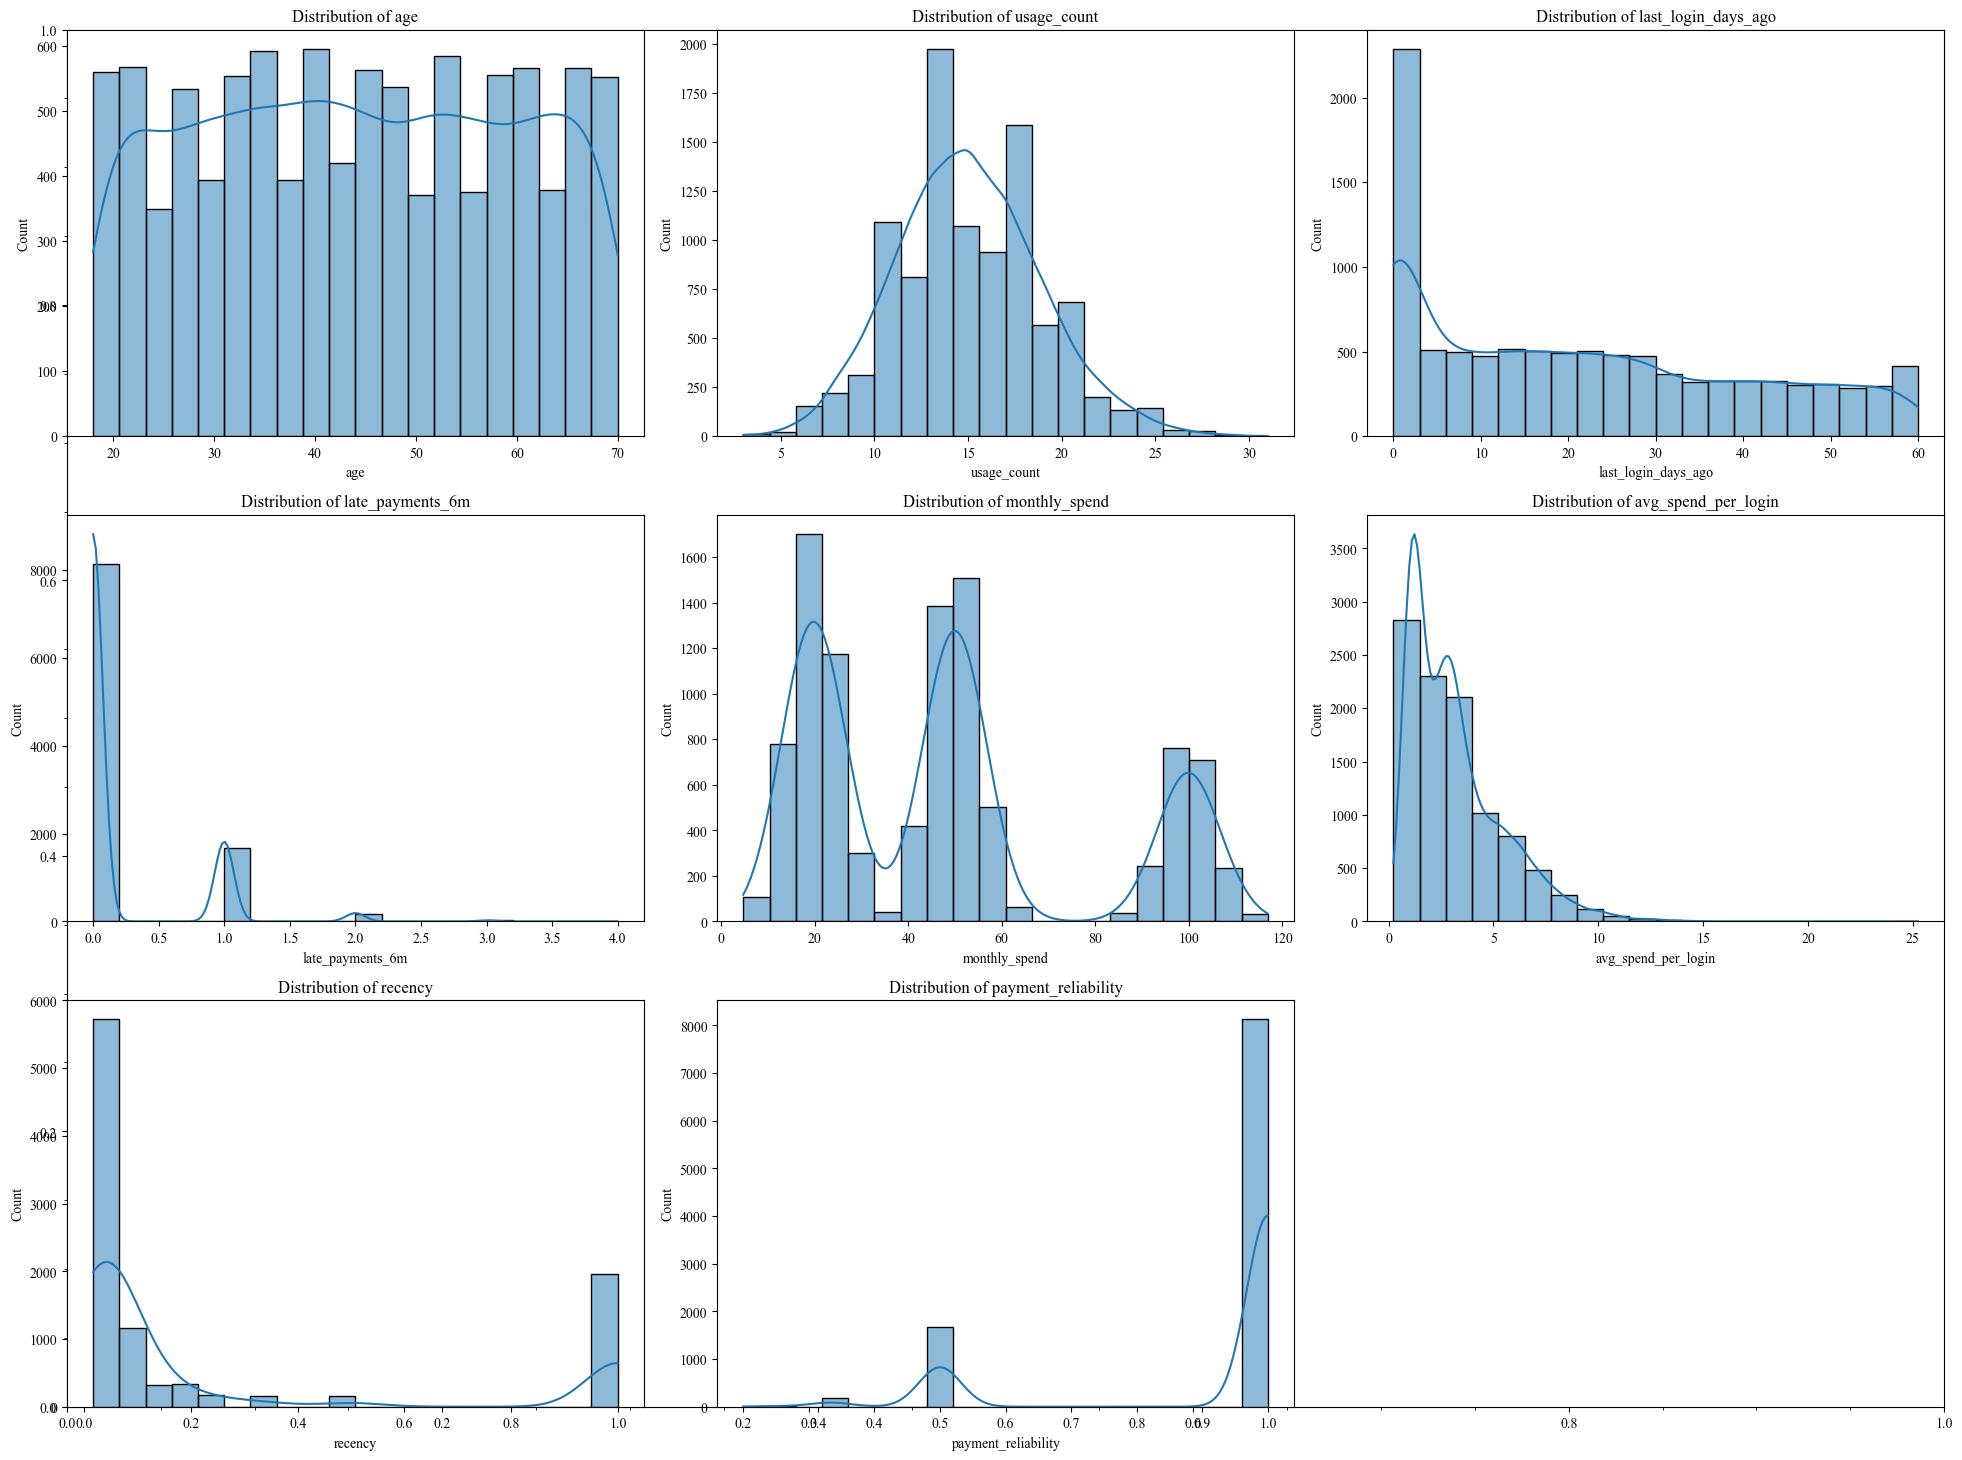

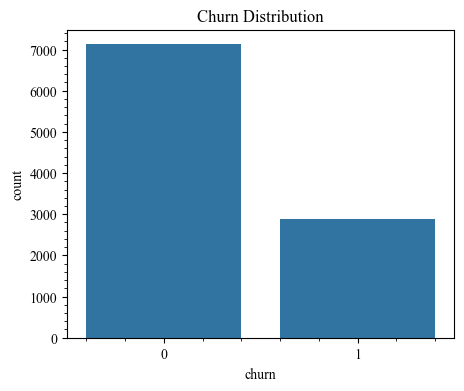

In [120]:
# Step 2.1: Univariate analysis 

# Histograms for numerical features 
numerical_features = ["age", "usage_count", "last_login_days_ago", "late_payments_6m",
    "monthly_spend", "avg_spend_per_login", "recency", "payment_reliability"]

plt.figure(figsize=(20,15))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_encoded[col], bins=20, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Churn distribution 
plt.figure(figsize=(5,4))
sns.countplot(x="churn", data=data_encoded)
plt.title("Churn Distribution")
plt.show()

### Step 2.1 Univariate analysis summary
- Age: Fairly uniform distribution with a slight concentration around the middle ages.
- Usage Count: Right-skewed with a higher number of lower usage counts.
- Last Login Days Ago: Peaks at recent logins (0-10 days), showing recency bias.
- Late Payments: Most customers have zero late payments, a few have 1-4.
-  Monthly Spend: Bimodal distribution suggesting different customer segments.
- Average Spend per Login: Skewed right, indicating some high spenders.
- Recency: Peaks for recent logins, expected due to inverse transformation.
- Payment Reliability: Mostly at 1 (no late payments).
- Churn: Imbalanced with more non-churners.

**Insights:**
- Imbalance in churn suggests we might need techniques like SMOTE or weighted models during prediction.
- The bimodal spend distribution hints at different customer segments (e.g., standard vs. premium).

## Step 2.2: Bivariate Analysis

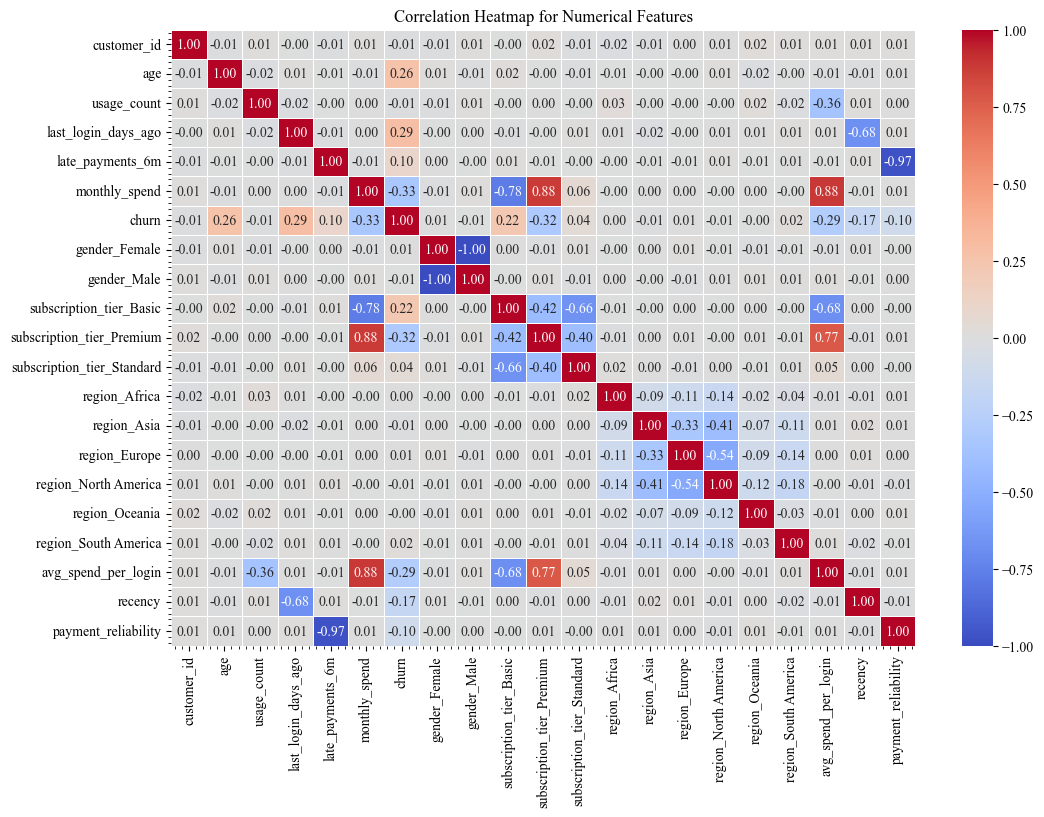

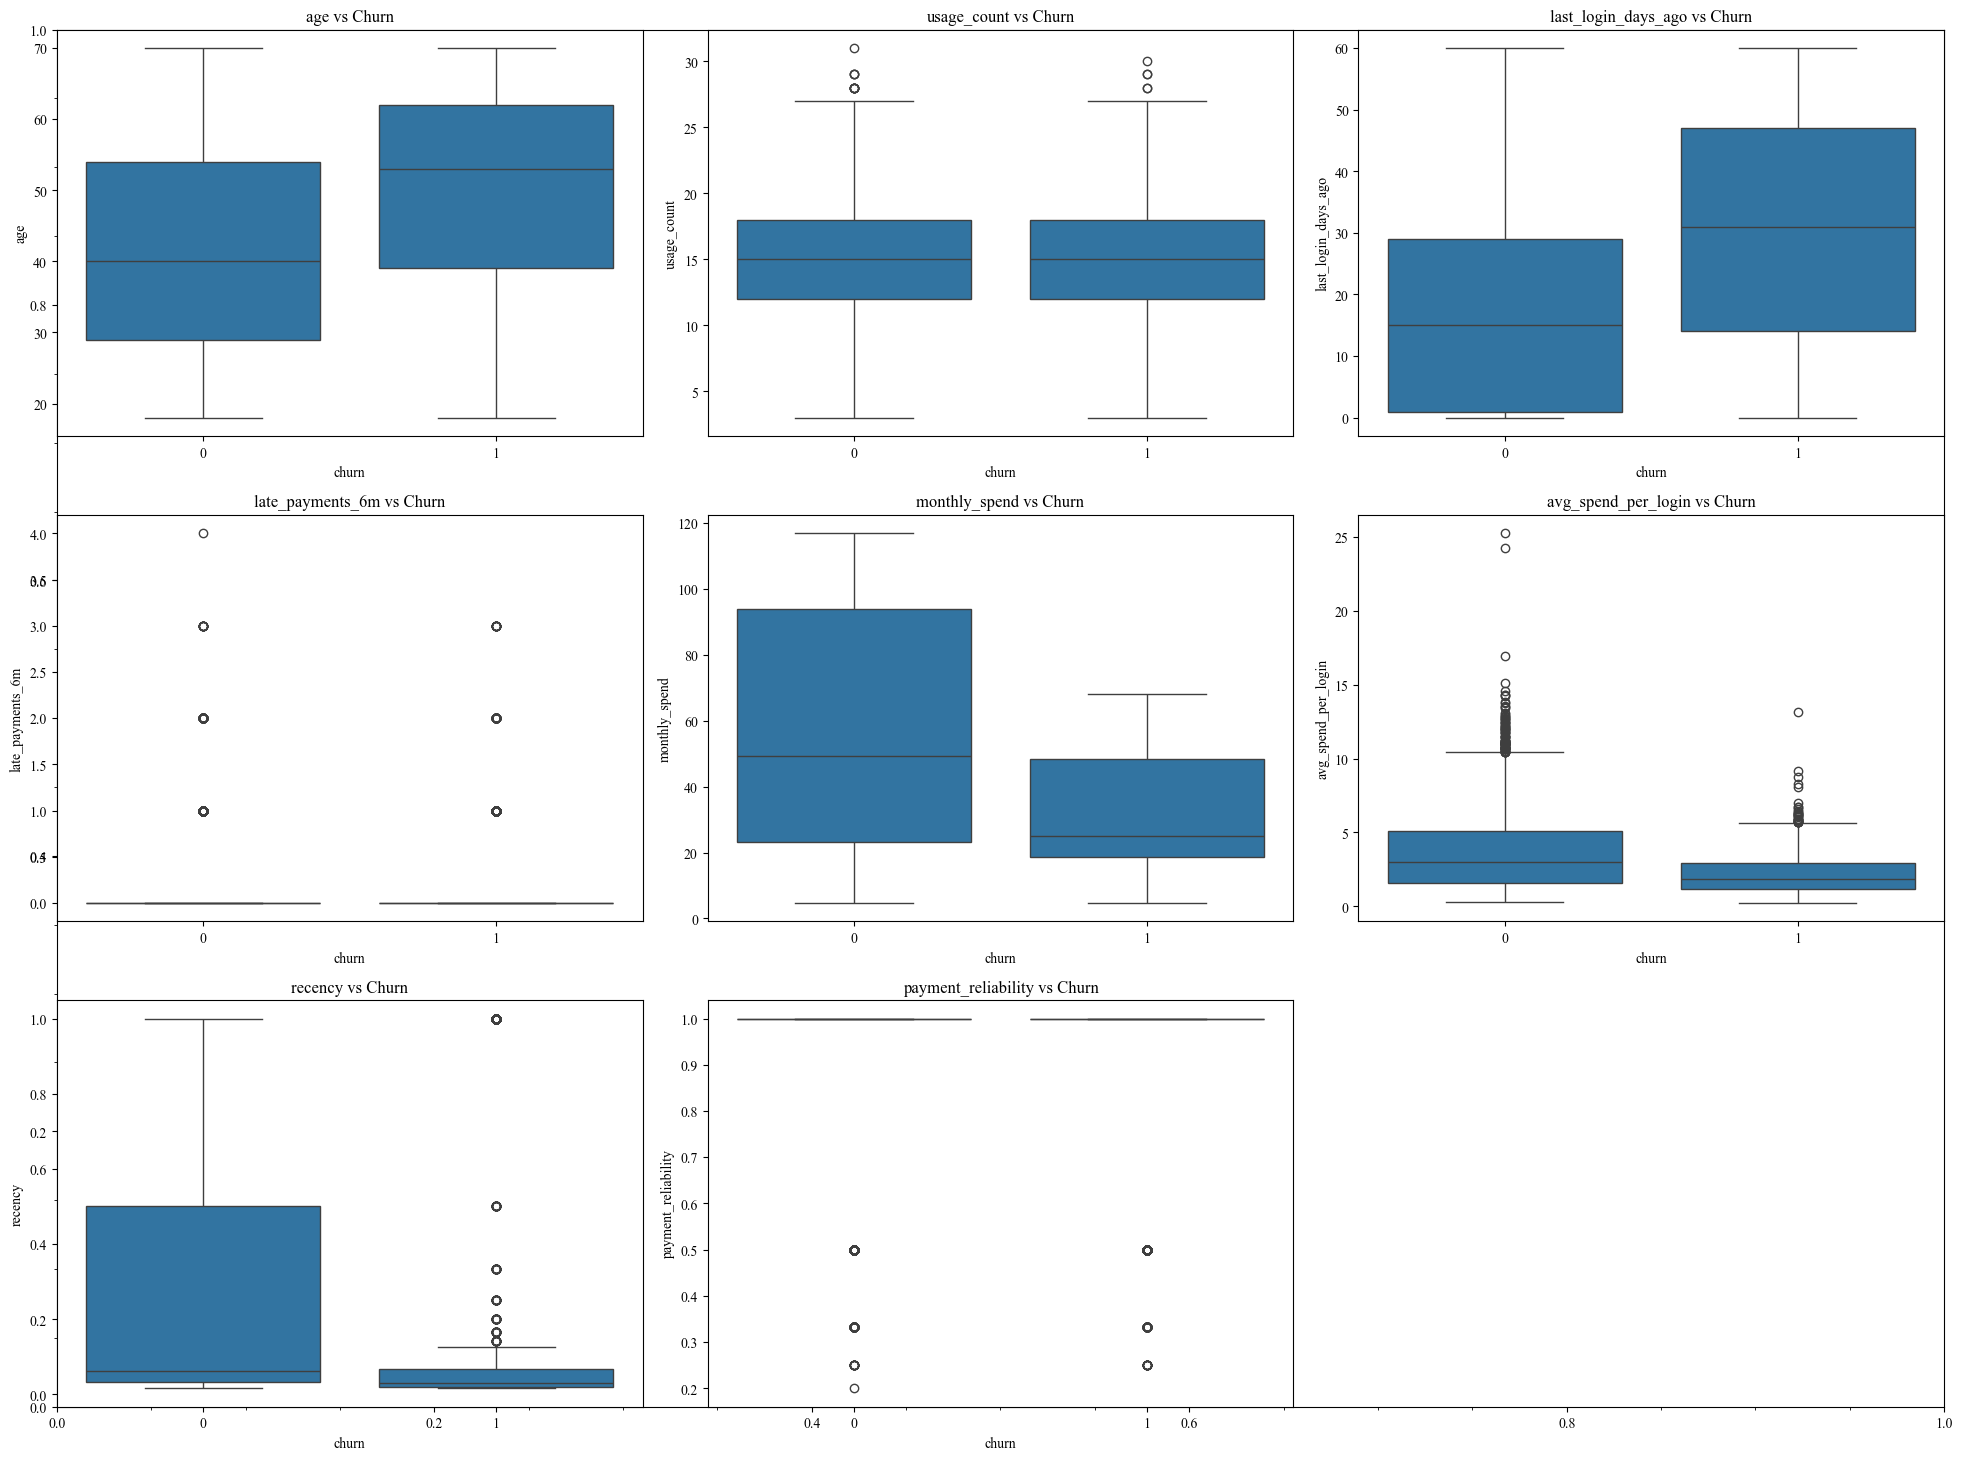

In [121]:
# Step 2.2: Bivarite analysis

# Correlation heatmap for numerical features
plt.figure(figsize=(12,8))
corr = data_encoded.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths = 0.5)
plt.title("Correlation Heatmap for Numerical Features")
plt.show()

# Box plots for numerical features against churn 
plt.figure(figsize=(20,15))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x="churn", y=col, data=data_encoded)
    plt.title(f"{col} vs Churn")
plt.tight_layout()
plt.show()

### Step 2.2: Bivariate analysis summary
1. **Correlation Heatmap:**
    - Monthly Spend and Subscription Tier: High positive correlation, suggesting premium tiers spend more.
    - Churn Correlations:
    - Negative correlation with Recency: Recent logins reduce churn likelihood.
    - Negative correlation with Payment Reliability: Reliable payers churn less.
    - Positive correlation with Late Payments: More late payments, higher churn.
2. **Box Plots (Churn vs Features):**
    - Age: Slightly lower for churners, but not very distinct.
    - Usage Count: Lower usage among churners.
    - Last Login Days Ago: Higher for churners, expected due to recency effect.
    - Late Payments: Significantly higher for churners.
    - Monthly Spend: Premium spenders seem to churn less.
    - Average Spend per Login: Lower for churners.
    - Recency: Higher for non-churners, indicating active users stay longer.
    - Payment Reliability: Higher for non-churners, reinforcing the reliability factor.
**Insights:**
- *Key Churn Indicators:*
    - Recency, Payment Reliability, and Late Payments are strong churn predictors.
- Premium customers churn less, likely due to higher engagement or loyalty.

## Step 2.3: Segment Analysis


In [122]:
# Step 2.3: Segment analysis

# Segmenting customers based on subscription tier and region 
subscription_segment = data_encoded.groupby("subscription_tier_Premium").agg({
    "churn": ["mean", "count"],
    "monthly_spend": "mean",
    "usage_count": "mean",
    "recency": "mean"
}).reset_index()

region_segment = data_encoded.groupby(["region_Asia", "region_Europe", "region_North America", 
                                       "region_Oceania", "region_South America", "region_Africa"]).agg({
    "churn": ["mean", "count"],
    "monthly_spend": "mean",
    "usage_count": "mean",
    "recency": "mean"
}).reset_index()

# Rename columns for clarity
region_segment.columns = ["region_Asia", "region_Europe", "region_North America", 
                          "region_Oceania", "region_South America", "region_Africa", "churn_rate", 
                          "customer_count", "avg_monthly_spend", "avg_usage_count", "avg_recency"]


print("Subscription based segmentation:")
print(subscription_segment)

print("Geografically based segmentation:")
print(region_segment)


Subscription based segmentation:
  subscription_tier_Premium    churn       monthly_spend usage_count   recency
                                mean count          mean        mean      mean
0                     False  0.36005  7985     34.628039   15.014527  0.255006
1                      True  0.00000  2015     99.960769   15.020347  0.245677
Geografically based segmentation:
   region_Asia  region_Europe  region_North America  region_Oceania  ...  customer_count  avg_monthly_spend  avg_usage_count  avg_recency
0        False          False                 False           False  ...             292          47.645479        15.595890     0.233615
1        False          False                 False           False  ...             451          47.196497        14.616408     0.217825
2        False          False                 False            True  ...             199          48.263869        15.557789     0.254227
3        False          False                  True           Fal

## Step 3: Predictive Modeling 
**Step 3.1: Feature Selection**
- **Goal:** Identify significant features for predicting churn.
- **Method:**
    - Use correlation analysis and feature importance from a preliminary Random Forest model.
    - Remove features with low importance or high multicollinearity.

**Step 3.2: Model Building**
- **Algorithms:**
    - Logistic Regression: For interpretability and understanding odds ratios.
    - Random Forest: For feature importance and handling non-linearity.
    - XGBoost: For accuracy and handling class imbalance.
- **Steps:**
    - Split the data into train and test sets (80-20 split).
    - Train and evaluate each model using cross-validation.
    - Address class imbalance if needed (SMOTE or class weights).

**Step 3.3: Model Evaluation**
- **Metrics:**
    - Accuracy
    - Precision, Recall, F1-score
    - ROC-AUC for overall performance
- **Feature Importance:**
    - Identify the top factors driving churn using Random Forest and XGBoost.

In [126]:
# Step 3.1: Feature selection using random forest 

# Define features and target 
features = data_encoded.drop(columns=["customer_id", "churn"])
target = data_encoded["churn"]

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importance 
feature_importance = pd.DataFrame({
    "Feature": features.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Feature Importance from RF:")
feature_importance

Feature Importance from RF:
Feature Importance from RF:


,Feature,Importance
0,age,0.182172
4,monthly_spend,0.172026
16,avg_spend_per_login,0.151878
2,last_login_days_ago,0.122745
17,recency,0.120585
1,usage_count,0.084328
8,subscription_tier_Premium,0.035971
13,region_North America,0.016013
12,region_Europe,0.014315
7,subscription_tier_Basic,0.013744


In [127]:
# Step 3.2: Model Building 

# Define models to train
models = {
    "logit": LogisticRegression(max_iter=1000, random_state=42),
    "RF": RandomForestClassifier(n_estimators=100, random_state=41),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=41)
}

# Train and evaluate each model
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })

# Convert results to DF for display 
results_df = pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False)
results_df

C:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:24:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,logit,0.7970,0.689655,0.525394,0.596421,0.850274
1,RF,0.7845,0.658371,0.509632,0.574531,0.823308
2,XGBoost,0.7660,0.610278,0.499124,0.549133,0.815482


**Insights:**
Relatively good preformance from the models, lets try with a SMOTE approach to see if it is possible to imporve.

In [128]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Re-train models with balanced data 
results_smote = []
for model_name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results_smote.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })

# Convert results to DF for display 
results_smote_df = pd.DataFrame(results_smote).sort_values(by="ROC AUC", ascending=False)
results_smote_df, results_df

C:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:24:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(     Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
 0    logit    0.7940   0.648598  0.607706  0.627486  0.846008
 2  XGBoost    0.7720   0.616162  0.534151  0.572233  0.820397
 1       RF    0.7655   0.596226  0.553415  0.574024  0.815769,
      Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
 0    logit    0.7970   0.689655  0.525394  0.596421  0.850274
 1       RF    0.7845   0.658371  0.509632  0.574531  0.823308
 2  XGBoost    0.7660   0.610278  0.499124  0.549133  0.815482)

In [135]:
# Step 3.3 Model Evaluation

# Define a function to evaluate models in detail 
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Confusion Matrix 
    cm = confusion_matrix(y_test, y_pred)

    # Classification report 
    report = classification_report(y_test, y_pred, target_names=["Non-Churn", "Churn"])
    return cm, report

# Evaluate each model 
evaluation_results = {}
for model_name, model in models.items():
    cm, report = evaluate_model(model, X_test, y_test)
    evaluation_results[model_name] = {
        "Confusion Matrix": cm,
        "Classification Report": report
    }

# Display results for each model
for model_name, results in evaluation_results.items():
    print(f"Model: {model_name}")
    print(f"Confusion Matrix:")
    print(results["Confusion Matrix"])
    print("\nClassification Report:")
    print(results["Classification Report"])
    print("\n" + "-" * 50 + "\n")



Model: logit
Confusion Matrix:
[[1241  188]
 [ 224  347]]

Classification Report:
              precision    recall  f1-score   support

   Non-Churn       0.85      0.87      0.86      1429
       Churn       0.65      0.61      0.63       571

    accuracy                           0.79      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.79      0.79      0.79      2000


--------------------------------------------------

Model: RF
Confusion Matrix:
[[1215  214]
 [ 255  316]]

Classification Report:
              precision    recall  f1-score   support

   Non-Churn       0.83      0.85      0.84      1429
       Churn       0.60      0.55      0.57       571

    accuracy                           0.77      2000
   macro avg       0.71      0.70      0.71      2000
weighted avg       0.76      0.77      0.76      2000


--------------------------------------------------

Model: XGBoost
Confusion Matrix:
[[1239  190]
 [ 266  305]]

Classification Rep

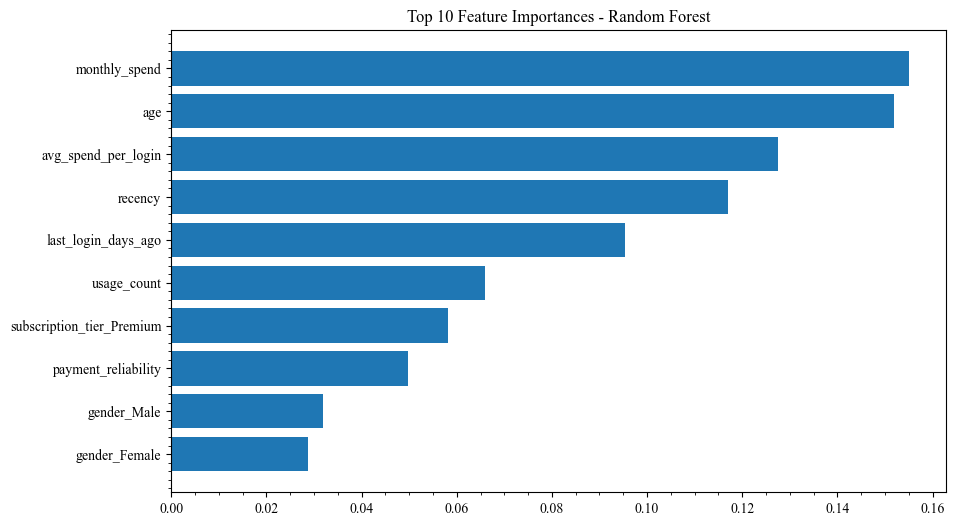

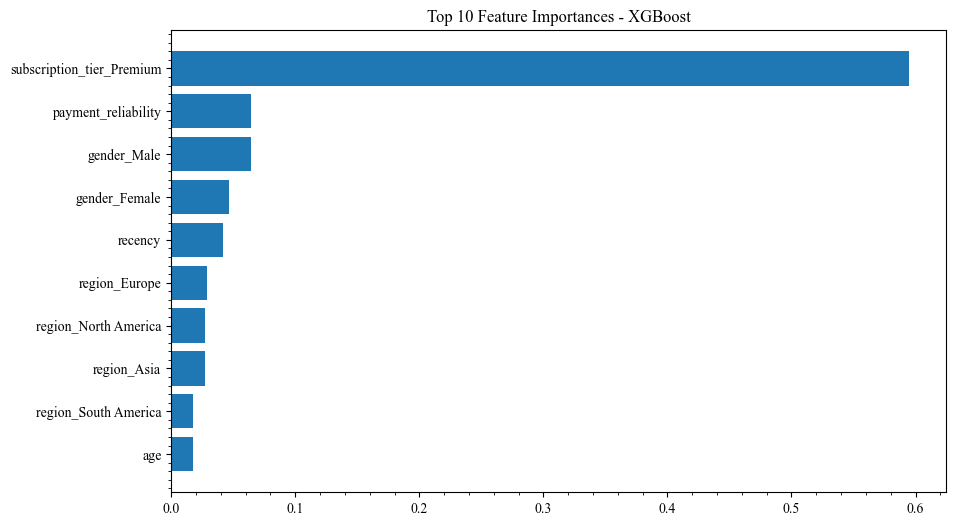

In [139]:
# Step 3.4: Feature Importance Analysis for XGBoost and Random Forest

# Extract feature importances for Random Forest
rf_importances = models["RF"].feature_importances_
rf_feature_importance = pd.DataFrame({
    "Feature": features.columns,
    "Importance": rf_importances
}).sort_values(by="Importance", ascending=False)

# Extract feature importances for XGBoost
xgb_importances = models["XGBoost"].feature_importances_
xgb_feature_importance = pd.DataFrame({
    "Feature": features.columns,
    "Importance": xgb_importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance["Feature"].head(10), rf_feature_importance["Importance"].head(10))
plt.title("Top 10 Feature Importances - Random Forest")
plt.gca().invert_yaxis()
plt.show()

# Plot feature importances for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance["Feature"].head(10), xgb_feature_importance["Importance"].head(10))
plt.title("Top 10 Feature Importances - XGBoost")
plt.gca().invert_yaxis()
plt.show()